Unit - 5

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm

# Set root directory where the folders are
root_dir = r"C:\Users\Dell\Downloads\dev-clean\dev-clean"

# Supported extensions
AUDIO_EXTENSIONS = ('.wav', '.mp3', '.flac', '.ogg')

# List to hold data
data = []

# Walk through folders
for root, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(AUDIO_EXTENSIONS):
            full_path = os.path.join(root, file)
            try:
                y, sr = librosa.load(full_path, sr=16000)
                duration = librosa.get_duration(y=y, sr=sr)
                mfcc = librosa.feature.mfcc(y=y, sr=sr)
                pitch = librosa.yin(y, fmin=50, fmax=300)
                energy = np.sum(y**2)/len(y)
                
                snr_estimate = 10 * np.log10(np.mean(y**2) / (np.var(y - np.mean(y)) + 1e-8))
                
                data.append({
                    "file_path": full_path,
                    "duration_sec": duration,
                    "mfcc_mean": mfcc.mean(),
                    "pitch_mean": pitch.mean(),
                    "energy": energy,
                    "sentence": "unknown",
                    "snr_db": snr_estimate
                })
            except Exception as e:
                print(f"Error processing {full_path}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data)

# Optional: classify audio as "clean" or "noisy" based on SNR threshold
df["label"] = df["snr_db"].apply(lambda x: "clean" if x > 10 else "noisy")

# Save for Power BI
df.to_csv("audio_features_metadata_5.csv", index=False)
print("Metadata and features saved.")

In [5]:
df

,file_path,duration_sec,mfcc_mean,pitch_mean,energy,sentence,snr_db,label
0,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,4.256,-19.936130,170.309389,0.004718,unknown,-0.000009,noisy
1,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,3.072,-19.217770,183.000636,0.006521,unknown,-0.000006,noisy
2,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,7.936,-23.359741,181.629704,0.003518,unknown,-0.000013,noisy
3,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,4.192,-19.572718,183.289807,0.006072,unknown,-0.000008,noisy
4,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,11.968,-23.073483,183.592144,0.004004,unknown,-0.000012,noisy
...,...,...,...,...,...,...,...,...
2698,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,4.864,-28.188143,234.600554,0.001484,unknown,-0.000029,noisy
2699,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,6.400,-28.525460,238.159868,0.001766,unknown,-0.000025,noisy
2700,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,4.736,-25.079040,250.216901,0.002063,unknown,-0.000021,noisy
2701,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,3.072,-26.802496,238.706155,0.002826,unknown,-0.000015,noisy


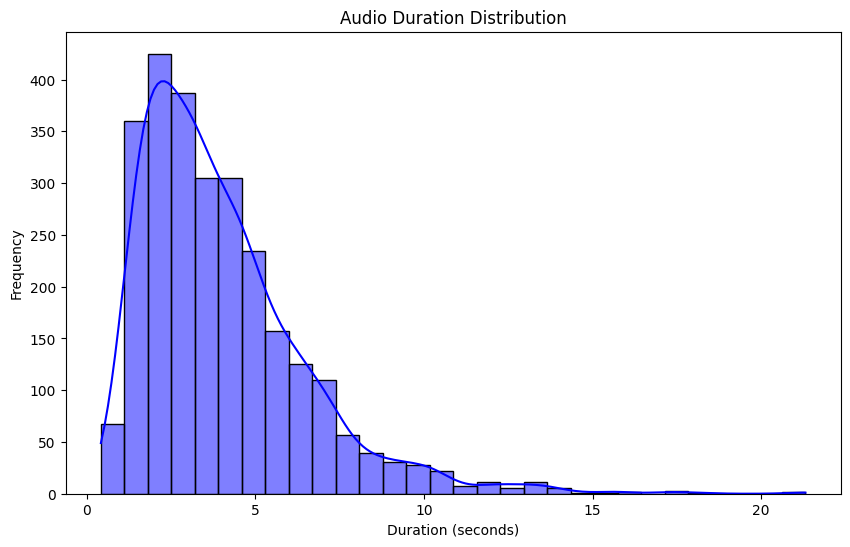

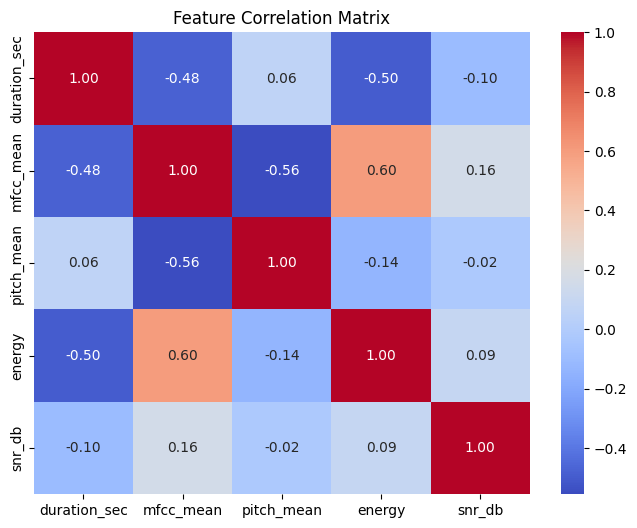

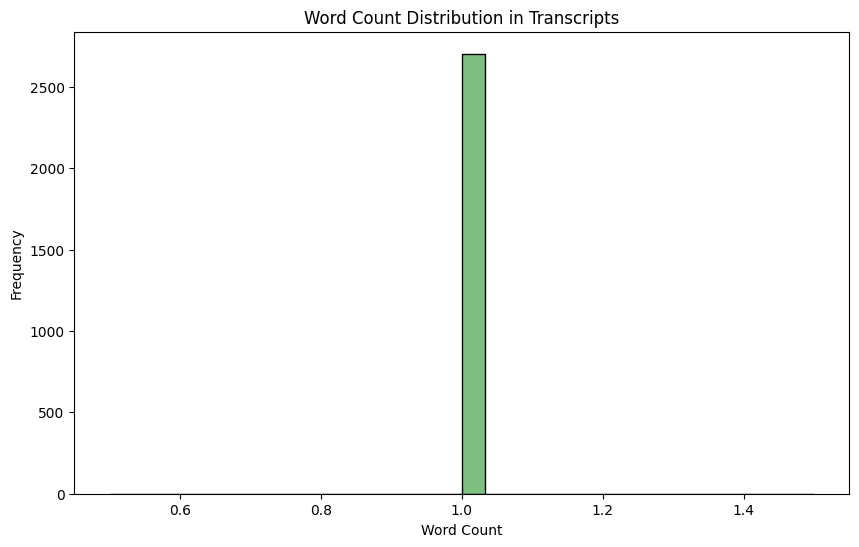

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Basic statistics of the audio features
audio_stats = df[['duration_sec', 'mfcc_mean', 'pitch_mean', 'energy', 'snr_db']].describe()

# Transcript analysis
df['word_count'] = df['sentence'].apply(lambda x: len(x.split()))
df['vocab_size'] = df['sentence'].apply(lambda x: len(set(x.split())))
df['avg_word_length'] = df['sentence'].apply(lambda x: np.mean([len(word) for word in x.split()]))

# Analyze the distribution of audio features
plt.figure(figsize=(10, 6))
sns.histplot(df['duration_sec'], kde=True, color='blue', bins=30)
plt.title('Audio Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Feature Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df[['duration_sec', 'mfcc_mean', 'pitch_mean', 'energy', 'snr_db']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Analyze transcript length and vocabulary size
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], kde=True, color='green', bins=30)
plt.title('Word Count Distribution in Transcripts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()



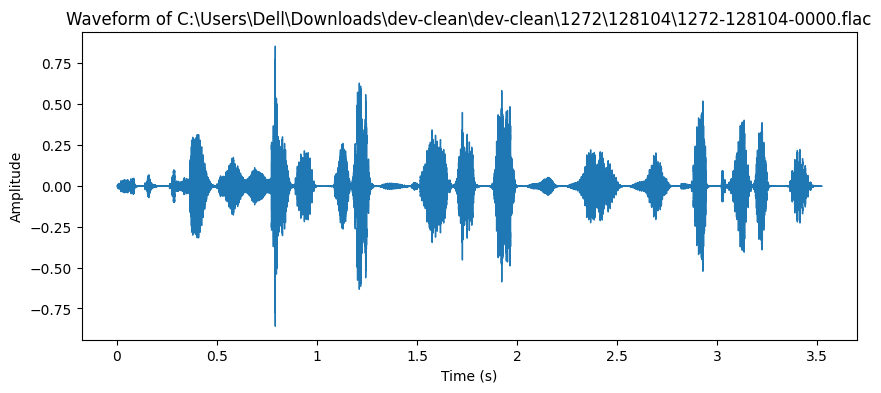

C:\Users\Dell\AppData\Local\Temp\ipykernel_5012\1574501177.py:15: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)


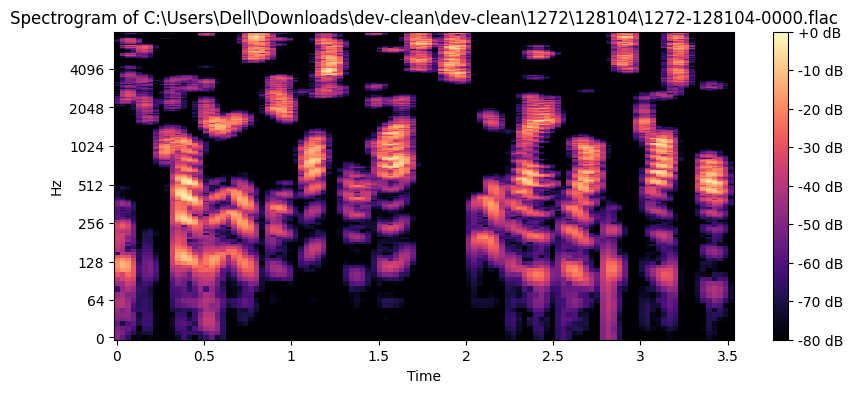

In [7]:
import librosa
import librosa.display

def plot_waveform(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f"Waveform of {file_path}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def plot_spectrogram(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
    plt.title(f"Spectrogram of {file_path}")
    plt.colorbar(format="%+2.0f dB")
    plt.show()

# Example: Visualize for a specific file
file_path = df['file_path'].iloc[0]  # Use the first file in your dataset
plot_waveform(file_path)
plot_spectrogram(file_path)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Preprocessing
X = df['sentence']
y = df['label']

# Encode labels (assuming `label` is categorical)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert sentences to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = vectorizer.transform(X_val).toarray()

# Create a custom Dataset class for PyTorch
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create DataLoader
train_data = TextDataset(X_train_tfidf, y_train)
val_data = TextDataset(X_val_tfidf, y_val)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [9]:
class SentimentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

# Initialize model, loss function, and optimizer
input_size = X_train_tfidf.shape[1]
hidden_size = 128
output_size = len(np.unique(y))  # Number of unique labels

model = SentimentModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [2/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [3/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [4/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [5/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [6/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [7/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0000, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0000, Accuracy: 100.00%


In [11]:
import torch

# Convert X_val_tfidf to a PyTorch tensor
X_val_tensor = torch.tensor(X_val_tfidf, dtype=torch.float32)

# Make sure that the model is in evaluation mode
model.eval()

# Get predictions from the model
with torch.no_grad():
    predictions = model(X_val_tensor)  # Forward pass with tensor input
    predicted_labels = torch.argmax(predictions, dim=1).numpy()  # Get predicted class labels

# Save results to a DataFrame
output_df = pd.DataFrame({
    "file_path": df['file_path'].iloc[X_val.index],  # Use X_val.index if necessary
    "predicted_label": predicted_labels,
    "true_label": y_val
})

# Save to CSV
output_df.to_csv('model_predictions.csv', index=False)

